In [48]:
import pandas as pd
import matplotlib.pyplot as plt

In [49]:
import glob 

path = 'data/PRSA_Data_20130301-20170228/'
csv_files = glob.glob(path + "/*.csv")

# Read each CSV file into DataFrame
# This creates a list of dataframes
df_list = [pd.read_csv(file) for file in csv_files]

In [50]:
def pre_process(df):
    df['date_time']=pd.to_datetime(df[['year', 'month', 'day','hour']])
    df.drop(columns=['year', 'month', 'day','hour','No'],inplace=True)
    df.set_index('date_time',inplace=True)
    return df

In [51]:
df_preprocessed=[pre_process(df) for df in df_list]

In [52]:
df_group=pd.concat(df_preprocessed)

In [53]:
def train_test_split(data,split_fraction,feature_keys):
    data=data[feature_keys]
    train_split = int(split_fraction * int(data.shape[0]))
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    data = (data - data_mean) / data_std
    train_data = data.iloc[0 : train_split - 1]
    val_data = data.iloc[train_split:]
    return train_data,val_data

def create_batch(data,lag,future):
    df_lag=pd.concat([data[:-future].shift(i) for i in range(lag-1,-1,-1)],axis=1).dropna()
    #df_lag.columns=['pm_'+str(i) for i in range(lag,-1,1)]
    X=df_lag.values
    y=data[future+lag-1:].values
    return X,y

In [54]:
import numpy as np 

split_fraction = 0.8
feature_keys = ['PM2.5']
X_train_datasets=list()
y_train_datasets=list()
X_test_datasets=list()
y_test_datasets=list()
future=1
past=6
dataset_names=list()
for item_id, gdf in df_group.groupby('station'):
    gdf.fillna(method='ffill',inplace=True)
    train,test=train_test_split(gdf,split_fraction,['PM2.5'])
    X_train,y_train=create_batch(train,past,future)
    X_test,y_test=create_batch(test,past,future)
    X_train_datasets.append(X_train)
    y_train_datasets.append(y_train)
    X_test_datasets.append(X_test)
    y_test_datasets.append(y_test)
    dataset_names.append(item_id)
X_train_datasets=np.stack(X_train_datasets,axis=0)
y_train_datasets=np.stack(y_train_datasets,axis=0)
X_test_datasets=np.stack(X_test_datasets,axis=0)
y_test_datasets=np.stack(y_test_datasets,axis=0)

In [56]:
import jax 
import jax.numpy as jnp 

def get_dataloader(X,y,batch_size,key,axis=0):
    num_train=X.shape[axis]
    indices = jnp.array(list(range(0,num_train)))
    indices=jax.random.permutation(key,indices)
    for i in range(0, len(indices),batch_size):
        batch_indices = jnp.array(indices[i: i+batch_size])
        yield X[:,batch_indices,:], y[:,batch_indices]

In [74]:
import optax
from flax import linen as nn
from functools import partial
import distrax

class LSTM(nn.Module):

    @nn.remat    
    @nn.compact   
    def __call__(self, X_batch):
        carry,x=nn.RNN(nn.LSTMCell(128),return_carry=True)(X_batch)
        x=nn.Dense(1)(x)
        return x[:,-1,:]
    

def reparameterize(params):
    mu = params['mu']
    sigma = jax.tree_map(lambda p : jnp.exp(0.5*p),params['log_std'])
    eps = params['eps']
    model_params = jax.tree_map(lambda m,e,s : m+e*s,mu,eps,sigma)
    return model_params

def log_likelihood(params, x, y):
    model_params=reparameterize(params)
    preds = jax.vmap(model.apply, (0, 0))(model_params, jnp.array(x[:,:,:,np.newaxis]))
    return jnp.mean(optax.l2_loss(y,preds).sum(axis=-1))

def log_prior(params):
    def flatten(params):
        squared=jax.tree_map(lambda p: distrax.Normal(0.0,1.0).log_prob(p).sum(), params)
        flattten_squared=jnp.sum(jnp.stack(jax.tree_util.tree_leaves(squared['params'])))
        return flattten_squared
    squared_mu=flatten(params['mu'])
    squared_noise=flatten(params['eps'])
    squared_std=flatten(params['log_std'])
    return squared_std+squared_noise+squared_mu

def log_post(params,batch,labels):
    n_data=batch.shape[0]
    return -1./n_data*(log_prior(params) + log_likelihood(params,batch,labels))

grad_log_post=jax.jit(jax.grad(log_post))

In [76]:
@partial(jax.jit, static_argnums=(3,4))
def sgld_kernel_momemtum(key, params, momemtum,grad_log_post, dt, X, y_data):
    gamma,eps=0.9,1e-6
    key, subkey = jax.random.split(key, 2)
    grads = grad_log_post(params, X, y_data)
    squared_grads=jax.tree_map(lambda g: jnp.square(g),grads)
    momemtum=jax.tree_map(lambda m,s : gamma*m+(1-gamma)*s,momemtum,squared_grads)
    noise=jax.tree_map(lambda p: jax.random.normal(key=subkey,shape=p.shape), params)
    params=jax.tree_map(lambda p, g,m,n: p-0.5*dt*g/(m+eps)+jnp.sqrt(dt)*n, params, grads,momemtum,noise)
    return key, params,momemtum

def sgld(key,log_post, grad_log_post, num_samples,
                             dt, x_0,X_train_datasets,y_train_datasets,batch_size,
                             test_data=None):
    samples = list()
    loss=list()
    param = x_0
    key_data, key_model = jax.random.split(key, 2)
    momemtum=jax.tree_map(lambda p:jnp.zeros_like(p),param)
    key_data_batch=jax.random.split(key_data, num_samples)
    for i in range(num_samples):
        train_data=get_dataloader(X_train_datasets,y_train_datasets,batch_size,key_data_batch[i],axis=1)
        for _,(X_batch, y_batch) in enumerate(train_data):
            key_model,param,momemtum = sgld_kernel_momemtum(key_model, param,momemtum, grad_log_post, dt, X_batch, y_batch)
        loss.append(log_post(param,X_batch,y_batch))
        samples.append(param)
        if (i%(num_samples//10)==0):
            print('iteration {0}, loss {1:.2f}'.format(i,loss[-1]))
    return samples,loss



In [77]:
key=jax.random.PRNGKey(0)
key_model,key_data=jax.random.split(key,2)
batch_size=256

In [80]:
model=LSTM()
n_groups=X_train_datasets.shape[0]
inputs = jax.random.randint(key_data,(batch_size,past,1),0, 10,).astype(jnp.float32)

In [81]:
key_model_init, key_state_init = jax.random.split(key_model, 2)
key_params_mu,key_params_sigma,key_params_eps=jax.random.split(key_model_init,3)
key_tasks=jax.random.split(key_params_eps,n_groups)

params_noise = jax.vmap(model.init, (0, None))(key_tasks, inputs)
params_mu=model.init(key_params_mu,inputs)
params_sigma=jax.tree_map(lambda p: distrax.Normal(0.0,1.0).sample(seed=key_params_sigma,sample_shape=(1,)),params_mu)


params_pooled = {
        'mu': params_mu,
        'eps': params_noise,
        'log_std': params_sigma,
    }

In [82]:
dt=1e-5
samples,loss=sgld(key_data,log_likelihood, grad_log_post, 10,
                             dt, params_pooled,X_train_datasets,y_train_datasets,
                             batch_size,test_data=None)

iteration 0, loss 0.08
iteration 1, loss 0.02
iteration 2, loss 0.02
iteration 3, loss 0.03
iteration 4, loss 0.02
iteration 5, loss 0.03
iteration 6, loss 0.02
iteration 7, loss 0.04
iteration 8, loss 0.04
iteration 9, loss 0.02


In [83]:
X_test=X_test_datasets[:,:,:,np.newaxis]
model_params=reparameterize(samples[-1])
preds=jax.vmap(model.apply, (0, 0))(model_params, X_test)

In [84]:
from sklearn import metrics

for i in range(n_groups):
    r_squared=metrics.r2_score(preds[i,:,:],y_test_datasets[i,:,:])
    rmse=metrics.mean_squared_error(preds[i,:,:],y_test_datasets[i,:,:],squared=True)
    mae=metrics.mean_absolute_error(preds[i,:,:],y_test_datasets[i,:,:])
    print('task : {0}, RMSE : {1:1.2f}, MAE :{2:1.2f}, R2 :{3:1.2f}'.format(dataset_names[i],rmse,mae,r_squared))

task : Aotizhongxin, RMSE : 0.05, MAE :0.13, R2 :0.95
task : Changping, RMSE : 0.07, MAE :0.13, R2 :0.93
task : Dingling, RMSE : 0.05, MAE :0.12, R2 :0.94
task : Dongsi, RMSE : 0.06, MAE :0.13, R2 :0.94
task : Guanyuan, RMSE : 0.06, MAE :0.13, R2 :0.94
task : Gucheng, RMSE : 0.07, MAE :0.13, R2 :0.94
task : Huairou, RMSE : 0.06, MAE :0.11, R2 :0.94
task : Nongzhanguan, RMSE : 0.05, MAE :0.12, R2 :0.95
task : Shunyi, RMSE : 0.06, MAE :0.12, R2 :0.94
task : Tiantan, RMSE : 0.05, MAE :0.13, R2 :0.95
task : Wanliu, RMSE : 0.05, MAE :0.12, R2 :0.95
task : Wanshouxigong, RMSE : 0.07, MAE :0.13, R2 :0.94


In [85]:
samples[-1].keys()

dict_keys(['eps', 'log_std', 'mu'])

In [86]:
jax.tree_map(jnp.shape,samples[-1]['mu'])

{'params': {'Dense_0': {'bias': (1,), 'kernel': (32, 1)},
  'LSTMCell_0': {'hf': {'bias': (32,), 'kernel': (32, 32)},
   'hg': {'bias': (32,), 'kernel': (32, 32)},
   'hi': {'bias': (32,), 'kernel': (32, 32)},
   'ho': {'bias': (32,), 'kernel': (32, 32)},
   'if': {'kernel': (1, 32)},
   'ig': {'kernel': (1, 32)},
   'ii': {'kernel': (1, 32)},
   'io': {'kernel': (1, 32)}}}}

In [87]:
jax.tree_map(jnp.shape,samples[-1]['log_std'])

{'params': {'Dense_0': {'bias': (1,), 'kernel': (1,)},
  'LSTMCell_0': {'hf': {'bias': (1,), 'kernel': (1,)},
   'hg': {'bias': (1,), 'kernel': (1,)},
   'hi': {'bias': (1,), 'kernel': (1,)},
   'ho': {'bias': (1,), 'kernel': (1,)},
   'if': {'kernel': (1,)},
   'ig': {'kernel': (1,)},
   'ii': {'kernel': (1,)},
   'io': {'kernel': (1,)}}}}

In [88]:
jax.tree_map(jnp.shape,samples[-1]['eps'])

{'params': {'Dense_0': {'bias': (12, 1), 'kernel': (12, 32, 1)},
  'LSTMCell_0': {'hf': {'bias': (12, 32), 'kernel': (12, 32, 32)},
   'hg': {'bias': (12, 32), 'kernel': (12, 32, 32)},
   'hi': {'bias': (12, 32), 'kernel': (12, 32, 32)},
   'ho': {'bias': (12, 32), 'kernel': (12, 32, 32)},
   'if': {'kernel': (12, 1, 32)},
   'ig': {'kernel': (12, 1, 32)},
   'ii': {'kernel': (12, 1, 32)},
   'io': {'kernel': (12, 1, 32)}}}}

In [89]:
ensemble_pred=list()
for i in range(len(samples)):
    model_params=reparameterize(samples[i])
    preds=jax.vmap(model.apply, (0, 0))(model_params, X_test)
    ensemble_pred.append(preds)

In [90]:
ensemble_pred=np.stack(ensemble_pred,axis=2)

In [91]:
mean_pred=np.mean(ensemble_pred,axis=2)
std_pred=np.std(ensemble_pred,axis=2)

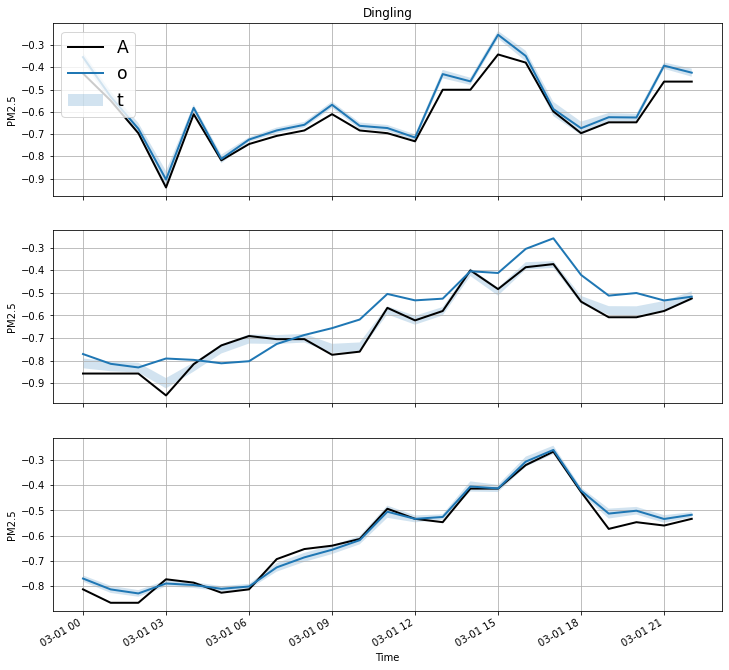

In [92]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12, 12))

names=np.ravel(gdf.index[0:23].to_frame().values)
ax1.plot(names,y_test_datasets[0,:23,:], linewidth=2,color="black")
ax1.plot(names,mean_pred[0,1:24,:], linewidth=2)
ax1.fill_between(names,np.ravel(mean_pred[0,1:24,:]-std_pred[0,1:24,:]),np.ravel(mean_pred[0,1:24,:]+std_pred[0,1:24,:]),alpha=0.2)
ax1.set_xlabel('Time')
ax1.set_ylabel('PM2.5')
ax1.legend(dataset_names[0], loc="upper left", fontsize="xx-large")
ax1.grid(True)

ax2.plot(names,y_test_datasets[1,:23,:], linewidth=2,color="black")
ax2.plot(names,mean_pred[2,1:24,:], linewidth=2)
ax2.fill_between(names,np.ravel(mean_pred[1,1:24,:]-std_pred[1,1:24,:]),np.ravel(mean_pred[1,1:24,:]+std_pred[1,1:24,:]),alpha=0.2)
ax2.set_xlabel('Time')
ax2.set_ylabel('PM2.5')
ax1.set_title(dataset_names[1])
ax2.grid(True)

ax3.plot(names,y_test_datasets[2,:23,:], linewidth=2,color="black")
ax3.plot(names,mean_pred[2,1:24,:], linewidth=2)
ax3.fill_between(names,np.ravel(mean_pred[2,1:24,:]-std_pred[2,1:24,:]),np.ravel(mean_pred[2,1:24,:]+std_pred[2,1:24,:]),alpha=0.2)
ax3.set_xlabel('Time')
ax3.set_ylabel('PM2.5')
ax1.set_title(dataset_names[2])
ax3.grid(True)

fig.autofmt_xdate()

In [452]:
class SimpleLSTM(nn.Module):
  features: int

  def setup(self):
    self.scan_cell = nn.transforms.scan(
      nn.OptimizedLSTMCell,
      variable_broadcast='params',
      in_axes=1, out_axes=1,
      split_rngs={'params': False})(self.features)

  @nn.compact
  def __call__(self, x):
    carry = self.scan_cell.initialize_carry(jax.random.PRNGKey(0), x[:, 0].shape)
    x=self.scan_cell(carry, x)[1]  # only return the output
    x=nn.Dense(1)(x)
    return x[:,-1,:]

In [453]:
fake_data=jnp.arange(0,8*2)
norm_fake_data=(fake_data-fake_data.mean())/fake_data.std()

In [454]:
x_fake,y_fake=create_batch(pd.DataFrame(norm_fake_data),6,1)
y_fake=y_fake.astype(float)

In [455]:
for xx,yy in zip(x_fake,y_fake):
    print(xx,yy)

[-1.6269784  -1.410048   -1.1931175  -0.97618705 -0.7592566  -0.54232615] [-0.32539567]
[-1.410048   -1.1931175  -0.97618705 -0.7592566  -0.54232615 -0.32539567] [-0.10846523]
[-1.1931175  -0.97618705 -0.7592566  -0.54232615 -0.32539567 -0.10846523] [0.10846523]
[-0.97618705 -0.7592566  -0.54232615 -0.32539567 -0.10846523  0.10846523] [0.32539567]
[-0.7592566  -0.54232615 -0.32539567 -0.10846523  0.10846523  0.32539567] [0.54232615]
[-0.54232615 -0.32539567 -0.10846523  0.10846523  0.32539567  0.54232615] [0.7592566]
[-0.32539567 -0.10846523  0.10846523  0.32539567  0.54232615  0.7592566 ] [0.97618705]
[-0.10846523  0.10846523  0.32539567  0.54232615  0.7592566   0.97618705] [1.1931175]
[0.10846523 0.32539567 0.54232615 0.7592566  0.97618705 1.1931175 ] [1.41004801]
[0.32539567 0.54232615 0.7592566  0.97618705 1.1931175  1.410048  ] [1.6269784]


In [456]:
simple_model=SimpleLSTM(8)
fake_key=jax.random.PRNGKey(0)
params=simple_model.init(fake_key,x_fake[:,:,np.newaxis])

In [462]:
import optax 

start_learning_rate = 1e-1
optimizer = optax.adam(start_learning_rate)
opt_state = optimizer.init(params)

In [463]:
def compute_loss(params,x,y):
    y_pred=simple_model.apply(params,x)
    return jnp.mean(optax.l2_loss(y,y_pred).sum(axis=-1))

In [464]:
# A simple update loop.
for i in range(100):
  loss,grads = jax.value_and_grad(compute_loss)(params, x_fake[:,:,np.newaxis], y_fake)
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  if (i%10==0):
    print(loss)


0.6247378
0.009109193
0.0045157894
0.0014280126
0.0005189054
0.0003519251
0.00023095577
0.000114046175
6.665256e-05
4.2850486e-05


In [466]:
y_pred=simple_model.apply(params,x_fake[:,:,np.newaxis])

In [467]:
for yz,yy in zip(y_pred,y_fake):
    print(fake_data.std()*yz+fake_data.mean(),fake_data.std()*yy+fake_data.mean())

[6.001205] [6.]
[6.9890814] [7.]
[8.013878] [8.]
[8.988622] [9.]
[9.989714] [10.]
[11.012798] [11.]
[11.999681] [12.]
[12.941533] [13.]
[14.07038] [14.]
[14.950382] [15.]
